In [396]:
#Import necessary dependencies or frameworks or libraries
from plotly import graph_objs as go;import copy; import datetime;import gc; gc.collect()
import numpy as np;import pandas as pd, os, gc;import seaborn as sns;from tqdm import tqdm; import missingno as msno
from sklearn.model_selection import KFold,cross_val_score,GroupKFold,RepeatedKFold,StratifiedKFold,GridSearchCV,cross_validate
import plotly.express as px;import math
from scipy import stats;import statsmodels.api as sm;from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor
import time;import warnings;from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split; from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer; import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, log_loss;from sklearn.feature_selection import mutual_info_classif
import lightgbm as lgb;from sklearn import metrics; from scipy.optimize import minimize
from lightgbm import LGBMClassifier; from catboost import CatBoostClassifier
warnings.filterwarnings('ignore')
from typing import List
import perfplot

In [397]:
#Data path & csv files name extension
data_path='/Users/DELL/Desktop/Hackhathons/Kowope/Data/'
train='Train.csv';test='Test.csv';submission ='SampleSubmission.csv'

In [398]:
#define some fxn to read the data set
def read_train():
    train_data =pd.read_csv(data_path + train)
    return train_data
def read_test():
    test_data =pd.read_csv(data_path + test)
    return test_data
def read_submission():
    sample_submission =pd.read_csv(data_path + submission)
    return sample_submission
#Assign defined fxns to variables
train = read_train();test=read_test();submission=read_submission()

In [399]:
train.head()

,Applicant_ID,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,...,form_field42,form_field43,form_field44,form_field45,form_field46,form_field47,form_field48,form_field49,form_field50,default_status
0,Apcnt_1000000,3436.0,0.28505,1.6560,0.0,0.000,0.0,10689720.0,252072.0,4272776.0,...,0.392854,2.02,0.711632,0.0,0.0,charge,NaN,1.129518,0.044335,no
1,Apcnt_1000004,3456.0,0.67400,0.2342,0.0,0.000,0.0,898979.0,497531.0,9073814.0,...,0.314281,8.08,0.183584,NaN,0.0,charge,349.805730,1.620483,0.322436,no
2,Apcnt_1000008,3276.0,0.53845,3.1510,0.0,6.282,NaN,956940.0,NaN,192944.0,...,0.162965,18.18,0.791136,0.0,0.0,charge,NaN,1.513370,0.011640,yes
3,Apcnt_1000012,3372.0,0.17005,0.5050,0.0,0.000,192166.0,3044703.0,385499.0,3986472.0,...,0.488884,2.02,0.685168,NaN,0.0,charge,89.940100,0.664452,0.082729,no
4,Apcnt_1000016,3370.0,0.77270,1.1010,0.0,0.000,1556.0,214728.0,214728.0,1284089.0,...,0.275000,12.12,0.438168,0.0,0.0,charge,97.887502,1.427891,0.045630,no


In [350]:
test=test.copy()

In [351]:
test_id=test['Applicant_ID']

In [352]:
train['default_status']= train['default_status'].replace({'yes': 1,'no': 0})

In [353]:
train.shape

(56000, 52)

In [354]:
train.isnull().sum()

Applicant_ID          0
form_field1        2529
form_field2        3844
form_field3         355
form_field4         355
form_field5         355
form_field6       13360
form_field7        5163
form_field8       13360
form_field9        8008
form_field10        355
form_field11      31421
form_field12       9895
form_field13       5889
form_field14          0
form_field15      22475
form_field16      13036
form_field17      11151
form_field18      10402
form_field19          4
form_field20        355
form_field21      15854
form_field22      20400
form_field23      28123
form_field24      13297
form_field25       5450
form_field26       7438
form_field27       9299
form_field28        355
form_field29        355
form_field30      25509
form_field31      39408
form_field32       5450
form_field33       1256
form_field34        355
form_field35      23148
form_field36       1995
form_field37       5450
form_field38        355
form_field39       4211
form_field40      43729
form_field41    

In [355]:
cols_to_drop=['form_field40','form_field41','form_field31','form_field48','form_field49']

In [356]:
train=train.drop(cols_to_drop, axis=1)

In [357]:
test=test.drop(cols_to_drop, axis=1)

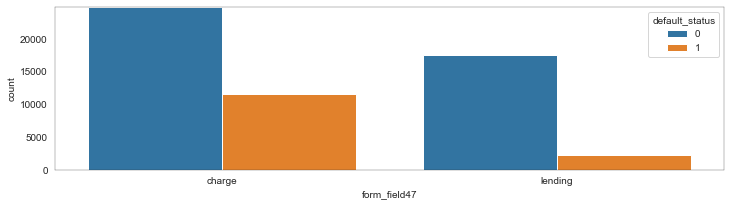

In [358]:
plt.figure(figsize=(12,3))
sns.set_style("white")
sns.countplot(x='form_field47', hue='default_status', data=train)
plt.show()

In [359]:
train.shape

(56000, 47)

In [360]:
features=['form_field1','form_field2']

In [361]:
data=pd.concat([train,test],sort=False).reset_index(drop=True)

In [362]:
def aggregate_features(x,col_name):
    x["min_"+col_name]=x[col_name].apply(np.min)
    x["max_"+col_name]=x[col_name].apply(np.max)
    x["mean_"+col_name]=x[col_name].apply(np.mean)
    x["median_"+col_name]=x[col_name].apply(np.median)
    return x  

In [363]:
for col_name in tqdm(features):
    data=aggregate_features(data,col_name)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.04s/it]


In [364]:
data['monthly_basis']=data['form_field14']/12

In [365]:
def chdx(data):
    if data.form_field1 <=3450:
        return 'ff-seg1'
    else:
        return 'ff-seg2'
data['ff1'] = data.apply(lambda data:chdx(data), axis=1)

In [366]:
def chdx2(data):
    if data.form_field30 <=5000:
        return 'ff-seg30'
    else:
        return 'ff-seg30x'
data['ff30'] = data.apply(lambda data:chdx2(data), axis=1)

In [367]:
def chdx3(data):
    if data.form_field42 <=0.30:
        return 'ff-seg42'
    elif data.form_field42 >0.30 and data.form_field42 <=1.50:
        return 'ff-seg42x'
    else:
        return 'ff-seg42xx'
data['ff42'] = data.apply(lambda data:chdx3(data), axis=1)

In [368]:
def worthy_level(x):
    if x <= 3484:
        return 'less-worthy'
    else:
        return 'worthy'
data['worth_level']= data['form_field1'].map(worthy_level)

In [369]:
data['Total_severity']=data['form_field3']+data['form_field4']+data['form_field5']
data['Total_loans_last2yrs']=data['form_field46']+data['form_field43']+data['form_field45']
data['Total _active credits']=data['form_field19']+data['form_field20']# or coconact
data['19/20']=data['form_field19']+data['form_field20']
data['Amount_paid_to_sum_due']=data['form_field13']-data['form_field12']
data['32/33']=data['form_field32']-data['form_field33']
data['14-13']=data['form_field14']-data['form_field13']
data['DX/DYAverage utilization']=data['form_field22']-data['form_field23']
data['Debt_to_income']=data['form_field13']/data['form_field14'] #try 12/14
data['Debt_to_income']=data['Debt_to_income'].round(2).astype(str) + '%'

In [370]:
bins = [0, 100000, 500000, 1000000,100000000, 500000000, 1014471051]
labels = ['extremely_low','low', 'medium', 'high','semi_high', 'extreme high']
data['Binned income'] = pd.cut(data['form_field14'], bins=bins, labels=labels)

In [371]:
data['form_field28']=np.log(data['form_field28'])
data['form_field13']=np.log(data['form_field13'])
data['form_field27']=np.log(data['form_field27'])
data['form_field29']=np.log(data['form_field29'])
data['form_field1']=np.log(data['form_field1'])

In [372]:
train=data[data.default_status.notnull()].reset_index(drop=True)
test=data[data.default_status.isna()].reset_index(drop=True)

In [373]:
train=train[[ 'form_field1','Binned income', 'Amount_paid_to_sum_due', 'form_field2', 'Debt_to_income', 'form_field3',
       'form_field4', 'form_field5', 'form_field6', 'form_field7',
       'form_field8', 'form_field9', 'form_field10', 'form_field11',
       'form_field12', 'form_field13', 'form_field14', 'form_field15',
       'form_field16', 'form_field17', 'form_field18', 'form_field19',
       'form_field20', 'form_field21', 'form_field22', 'form_field23',
       'form_field24', 'form_field25', 'form_field26', 'form_field27',
       'form_field28', 'form_field29', 'form_field30', 'form_field32',
       'form_field33', 'form_field34', 'form_field35', 'form_field36',
       'form_field37', 'form_field38', 'form_field39', 'form_field42',
       'form_field43', 'form_field44', 'form_field45', 'form_field46',
       'form_field47', 'form_field50', 'default_status', 'min_form_field1',
       'max_form_field1', 'mean_form_field1', 'median_form_field1',
       'min_form_field2', 'max_form_field2', 'mean_form_field2',
       'median_form_field2', 'monthly_basis', 'ff1', 'ff30', 'ff42',
       'worth_level', 'Total_severity', 'Total_loans_last2yrs',
       'Total _active credits', '19/20', '32/33',
       '14-13', 'DX/DYAverage utilization']]
test=test[['form_field1','Binned income', 'Amount_paid_to_sum_due', 'form_field2', 'Debt_to_income', 'form_field3',
       'form_field4', 'form_field5', 'form_field6', 'form_field7',
       'form_field8', 'form_field9', 'form_field10', 'form_field11',
       'form_field12', 'form_field13', 'form_field14', 'form_field15',
       'form_field16', 'form_field17', 'form_field18', 'form_field19',
       'form_field20', 'form_field21', 'form_field22', 'form_field23',
       'form_field24', 'form_field25', 'form_field26', 'form_field27',
       'form_field28', 'form_field29', 'form_field30', 'form_field32',
       'form_field33', 'form_field34', 'form_field35', 'form_field36',
       'form_field37', 'form_field38', 'form_field39', 'form_field42',
       'form_field43', 'form_field44', 'form_field45', 'form_field46',
       'form_field47', 'form_field50', 'min_form_field1',
       'max_form_field1', 'mean_form_field1', 'median_form_field1',
       'min_form_field2', 'max_form_field2', 'mean_form_field2',
       'median_form_field2', 'monthly_basis', 'ff1', 'ff30', 'ff42',
       'worth_level', 'Total_severity', 'Total_loans_last2yrs',
       'Total _active credits', '19/20', '32/33',
       '14-13', 'DX/DYAverage utilization']]

In [374]:
train.shape, test.shape

((56000, 69), (24000, 68))

In [375]:
X=train.drop(['default_status'], axis=1)
y=train.default_status

In [376]:
y

0        0.0
1        0.0
2        1.0
3        0.0
4        0.0
        ... 
55995    0.0
55996    1.0
55997    0.0
55998    0.0
55999    0.0
Name: default_status, Length: 56000, dtype: float64

In [377]:
X.fillna(method='ffill', inplace=True)
test.fillna(method='ffill', inplace=True)

In [378]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=12345)

In [379]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]

In [390]:
from sklearn.model_selection import cross_val_score, train_test_split, KFold, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score
errcb=[]
y_pred_totcb=[]
fold=StratifiedKFold(n_splits=7, random_state=7, shuffle =True)#4splits state 0 no shufflr
i=1
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m = CatBoostClassifier(eval_metric='AUC', learning_rate=0.1,  depth=4, iterations=800)
    m.fit(X,y,cat_features=categorical_features_indices)
    #m.fit(X_train,y_train,cat_features=categorical_features_indices,eval_set=[(X_train,y_train),(X_val, y_val)],verbose=100, early_stopping_rounds=100)#,verbose=100)
    preds=m.predict_proba(X_test)[:, 1]
    print("err: ",roc_auc_score(y_test,preds))
    errcb.append(roc_auc_score(y_test,preds))
    p = m.predict_proba(test)[:, 1]
    y_pred_totcb.append(p) #0.84453 with 1500

0:	total: 63.2ms	remaining: 50.5s
1:	total: 136ms	remaining: 54.2s
2:	total: 200ms	remaining: 53.3s
3:	total: 273ms	remaining: 54.3s
4:	total: 335ms	remaining: 53.2s
5:	total: 404ms	remaining: 53.4s
6:	total: 477ms	remaining: 54s
7:	total: 544ms	remaining: 53.9s
8:	total: 628ms	remaining: 55.2s
9:	total: 693ms	remaining: 54.8s
10:	total: 763ms	remaining: 54.7s
11:	total: 847ms	remaining: 55.6s
12:	total: 909ms	remaining: 55s
13:	total: 992ms	remaining: 55.7s
14:	total: 1.06s	remaining: 55.5s
15:	total: 1.12s	remaining: 55.1s
16:	total: 1.19s	remaining: 54.9s
17:	total: 1.26s	remaining: 54.8s
18:	total: 1.33s	remaining: 54.6s
19:	total: 1.39s	remaining: 54.3s
20:	total: 1.46s	remaining: 54.2s
21:	total: 1.52s	remaining: 53.9s
22:	total: 1.58s	remaining: 53.6s
23:	total: 1.65s	remaining: 53.5s
24:	total: 1.73s	remaining: 53.5s
25:	total: 1.79s	remaining: 53.2s
26:	total: 1.85s	remaining: 52.9s
27:	total: 1.92s	remaining: 52.8s
28:	total: 1.99s	remaining: 52.9s
29:	total: 2.07s	remaining:

240:	total: 17.2s	remaining: 39.9s
241:	total: 17.3s	remaining: 39.8s
242:	total: 17.3s	remaining: 39.7s
243:	total: 17.4s	remaining: 39.7s
244:	total: 17.5s	remaining: 39.6s
245:	total: 17.5s	remaining: 39.5s
246:	total: 17.6s	remaining: 39.5s
247:	total: 17.7s	remaining: 39.5s
248:	total: 17.8s	remaining: 39.4s
249:	total: 17.9s	remaining: 39.4s
250:	total: 18s	remaining: 39.3s
251:	total: 18s	remaining: 39.2s
252:	total: 18.1s	remaining: 39.2s
253:	total: 18.2s	remaining: 39.1s
254:	total: 18.3s	remaining: 39s
255:	total: 18.3s	remaining: 38.9s
256:	total: 18.4s	remaining: 38.9s
257:	total: 18.5s	remaining: 38.8s
258:	total: 18.5s	remaining: 38.7s
259:	total: 18.6s	remaining: 38.6s
260:	total: 18.7s	remaining: 38.6s
261:	total: 18.8s	remaining: 38.6s
262:	total: 18.9s	remaining: 38.5s
263:	total: 18.9s	remaining: 38.5s
264:	total: 19s	remaining: 38.4s
265:	total: 19.1s	remaining: 38.4s
266:	total: 19.2s	remaining: 38.3s
267:	total: 19.3s	remaining: 38.2s
268:	total: 19.3s	remaining:

477:	total: 35.9s	remaining: 24.2s
478:	total: 36s	remaining: 24.1s
479:	total: 36.1s	remaining: 24s
480:	total: 36.1s	remaining: 24s
481:	total: 36.2s	remaining: 23.9s
482:	total: 36.3s	remaining: 23.8s
483:	total: 36.4s	remaining: 23.7s
484:	total: 36.4s	remaining: 23.7s
485:	total: 36.5s	remaining: 23.6s
486:	total: 36.6s	remaining: 23.5s
487:	total: 36.6s	remaining: 23.4s
488:	total: 36.7s	remaining: 23.4s
489:	total: 36.8s	remaining: 23.3s
490:	total: 36.9s	remaining: 23.2s
491:	total: 36.9s	remaining: 23.1s
492:	total: 37s	remaining: 23s
493:	total: 37.1s	remaining: 23s
494:	total: 37.2s	remaining: 22.9s
495:	total: 37.2s	remaining: 22.8s
496:	total: 37.3s	remaining: 22.8s
497:	total: 37.4s	remaining: 22.7s
498:	total: 37.5s	remaining: 22.6s
499:	total: 37.6s	remaining: 22.6s
500:	total: 37.7s	remaining: 22.5s
501:	total: 37.8s	remaining: 22.4s
502:	total: 37.8s	remaining: 22.3s
503:	total: 37.9s	remaining: 22.3s
504:	total: 38s	remaining: 22.2s
505:	total: 38.1s	remaining: 22.1s

714:	total: 53.8s	remaining: 6.4s
715:	total: 53.9s	remaining: 6.32s
716:	total: 54s	remaining: 6.25s
717:	total: 54s	remaining: 6.17s
718:	total: 54.1s	remaining: 6.09s
719:	total: 54.2s	remaining: 6.02s
720:	total: 54.2s	remaining: 5.94s
721:	total: 54.3s	remaining: 5.87s
722:	total: 54.4s	remaining: 5.79s
723:	total: 54.4s	remaining: 5.71s
724:	total: 54.5s	remaining: 5.64s
725:	total: 54.6s	remaining: 5.56s
726:	total: 54.6s	remaining: 5.49s
727:	total: 54.7s	remaining: 5.41s
728:	total: 54.8s	remaining: 5.33s
729:	total: 54.8s	remaining: 5.26s
730:	total: 54.9s	remaining: 5.18s
731:	total: 54.9s	remaining: 5.1s
732:	total: 55s	remaining: 5.03s
733:	total: 55.1s	remaining: 4.95s
734:	total: 55.2s	remaining: 4.88s
735:	total: 55.2s	remaining: 4.8s
736:	total: 55.3s	remaining: 4.72s
737:	total: 55.3s	remaining: 4.65s
738:	total: 55.4s	remaining: 4.57s
739:	total: 55.5s	remaining: 4.5s
740:	total: 55.5s	remaining: 4.42s
741:	total: 55.6s	remaining: 4.34s
742:	total: 55.6s	remaining: 4

153:	total: 11.3s	remaining: 47.5s
154:	total: 11.4s	remaining: 47.4s
155:	total: 11.5s	remaining: 47.3s
156:	total: 11.5s	remaining: 47.1s
157:	total: 11.6s	remaining: 47s
158:	total: 11.6s	remaining: 46.9s
159:	total: 11.7s	remaining: 46.8s
160:	total: 11.8s	remaining: 46.7s
161:	total: 11.8s	remaining: 46.6s
162:	total: 11.9s	remaining: 46.5s
163:	total: 12s	remaining: 46.5s
164:	total: 12s	remaining: 46.4s
165:	total: 12.1s	remaining: 46.3s
166:	total: 12.2s	remaining: 46.2s
167:	total: 12.3s	remaining: 46.1s
168:	total: 12.3s	remaining: 46s
169:	total: 12.4s	remaining: 45.9s
170:	total: 12.4s	remaining: 45.8s
171:	total: 12.5s	remaining: 45.7s
172:	total: 12.6s	remaining: 45.6s
173:	total: 12.6s	remaining: 45.5s
174:	total: 12.7s	remaining: 45.4s
175:	total: 12.8s	remaining: 45.3s
176:	total: 12.9s	remaining: 45.3s
177:	total: 12.9s	remaining: 45.2s
178:	total: 13s	remaining: 45.2s
179:	total: 13.1s	remaining: 45.2s
180:	total: 13.2s	remaining: 45.1s
181:	total: 13.3s	remaining: 4

390:	total: 29.4s	remaining: 30.8s
391:	total: 29.5s	remaining: 30.7s
392:	total: 29.6s	remaining: 30.6s
393:	total: 29.6s	remaining: 30.5s
394:	total: 29.7s	remaining: 30.5s
395:	total: 29.8s	remaining: 30.4s
396:	total: 29.9s	remaining: 30.3s
397:	total: 30s	remaining: 30.3s
398:	total: 30s	remaining: 30.2s
399:	total: 30.1s	remaining: 30.1s
400:	total: 30.2s	remaining: 30s
401:	total: 30.3s	remaining: 29.9s
402:	total: 30.3s	remaining: 29.9s
403:	total: 30.4s	remaining: 29.8s
404:	total: 30.5s	remaining: 29.7s
405:	total: 30.5s	remaining: 29.6s
406:	total: 30.6s	remaining: 29.6s
407:	total: 30.7s	remaining: 29.5s
408:	total: 30.8s	remaining: 29.4s
409:	total: 30.9s	remaining: 29.4s
410:	total: 30.9s	remaining: 29.3s
411:	total: 31s	remaining: 29.2s
412:	total: 31.1s	remaining: 29.1s
413:	total: 31.1s	remaining: 29s
414:	total: 31.2s	remaining: 29s
415:	total: 31.3s	remaining: 28.9s
416:	total: 31.4s	remaining: 28.8s
417:	total: 31.4s	remaining: 28.7s
418:	total: 31.5s	remaining: 28.

627:	total: 47.2s	remaining: 12.9s
628:	total: 47.3s	remaining: 12.9s
629:	total: 47.4s	remaining: 12.8s
630:	total: 47.4s	remaining: 12.7s
631:	total: 47.5s	remaining: 12.6s
632:	total: 47.6s	remaining: 12.6s
633:	total: 47.6s	remaining: 12.5s
634:	total: 47.7s	remaining: 12.4s
635:	total: 47.8s	remaining: 12.3s
636:	total: 47.9s	remaining: 12.2s
637:	total: 47.9s	remaining: 12.2s
638:	total: 48s	remaining: 12.1s
639:	total: 48.1s	remaining: 12s
640:	total: 48.1s	remaining: 11.9s
641:	total: 48.2s	remaining: 11.9s
642:	total: 48.3s	remaining: 11.8s
643:	total: 48.4s	remaining: 11.7s
644:	total: 48.4s	remaining: 11.6s
645:	total: 48.5s	remaining: 11.6s
646:	total: 48.6s	remaining: 11.5s
647:	total: 48.6s	remaining: 11.4s
648:	total: 48.7s	remaining: 11.3s
649:	total: 48.8s	remaining: 11.3s
650:	total: 48.9s	remaining: 11.2s
651:	total: 48.9s	remaining: 11.1s
652:	total: 49s	remaining: 11s
653:	total: 49.1s	remaining: 11s
654:	total: 49.1s	remaining: 10.9s
655:	total: 49.2s	remaining: 1

66:	total: 5.13s	remaining: 56.1s
67:	total: 5.2s	remaining: 56s
68:	total: 5.27s	remaining: 55.8s
69:	total: 5.34s	remaining: 55.7s
70:	total: 5.41s	remaining: 55.6s
71:	total: 5.49s	remaining: 55.5s
72:	total: 5.56s	remaining: 55.4s
73:	total: 5.63s	remaining: 55.2s
74:	total: 5.7s	remaining: 55.1s
75:	total: 5.78s	remaining: 55s
76:	total: 5.84s	remaining: 54.9s
77:	total: 5.91s	remaining: 54.7s
78:	total: 5.99s	remaining: 54.7s
79:	total: 6.07s	remaining: 54.7s
80:	total: 6.15s	remaining: 54.6s
81:	total: 6.22s	remaining: 54.5s
82:	total: 6.29s	remaining: 54.4s
83:	total: 6.37s	remaining: 54.3s
84:	total: 6.44s	remaining: 54.2s
85:	total: 6.51s	remaining: 54.1s
86:	total: 6.58s	remaining: 54s
87:	total: 6.66s	remaining: 53.9s
88:	total: 6.73s	remaining: 53.8s
89:	total: 6.81s	remaining: 53.7s
90:	total: 6.88s	remaining: 53.6s
91:	total: 6.96s	remaining: 53.5s
92:	total: 7.03s	remaining: 53.5s
93:	total: 7.12s	remaining: 53.5s
94:	total: 7.2s	remaining: 53.4s
95:	total: 7.27s	remain

304:	total: 25s	remaining: 40.6s
305:	total: 25.1s	remaining: 40.5s
306:	total: 25.2s	remaining: 40.4s
307:	total: 25.3s	remaining: 40.3s
308:	total: 25.3s	remaining: 40.2s
309:	total: 25.4s	remaining: 40.1s
310:	total: 25.5s	remaining: 40s
311:	total: 25.5s	remaining: 39.9s
312:	total: 25.6s	remaining: 39.9s
313:	total: 25.7s	remaining: 39.8s
314:	total: 25.8s	remaining: 39.7s
315:	total: 25.8s	remaining: 39.5s
316:	total: 25.9s	remaining: 39.5s
317:	total: 26s	remaining: 39.4s
318:	total: 26.1s	remaining: 39.3s
319:	total: 26.1s	remaining: 39.2s
320:	total: 26.2s	remaining: 39.1s
321:	total: 26.3s	remaining: 39s
322:	total: 26.4s	remaining: 38.9s
323:	total: 26.4s	remaining: 38.8s
324:	total: 26.5s	remaining: 38.7s
325:	total: 26.6s	remaining: 38.6s
326:	total: 26.6s	remaining: 38.5s
327:	total: 26.7s	remaining: 38.4s
328:	total: 26.8s	remaining: 38.3s
329:	total: 26.9s	remaining: 38.2s
330:	total: 26.9s	remaining: 38.2s
331:	total: 27s	remaining: 38.1s
332:	total: 27.1s	remaining: 3

541:	total: 43.9s	remaining: 20.9s
542:	total: 43.9s	remaining: 20.8s
543:	total: 44s	remaining: 20.7s
544:	total: 44.1s	remaining: 20.6s
545:	total: 44.1s	remaining: 20.5s
546:	total: 44.2s	remaining: 20.5s
547:	total: 44.3s	remaining: 20.4s
548:	total: 44.4s	remaining: 20.3s
549:	total: 44.4s	remaining: 20.2s
550:	total: 44.5s	remaining: 20.1s
551:	total: 44.6s	remaining: 20s
552:	total: 44.7s	remaining: 20s
553:	total: 44.8s	remaining: 19.9s
554:	total: 44.8s	remaining: 19.8s
555:	total: 44.9s	remaining: 19.7s
556:	total: 45s	remaining: 19.6s
557:	total: 45.1s	remaining: 19.5s
558:	total: 45.1s	remaining: 19.5s
559:	total: 45.2s	remaining: 19.4s
560:	total: 45.3s	remaining: 19.3s
561:	total: 45.3s	remaining: 19.2s
562:	total: 45.4s	remaining: 19.1s
563:	total: 45.5s	remaining: 19s
564:	total: 45.6s	remaining: 19s
565:	total: 45.7s	remaining: 18.9s
566:	total: 45.7s	remaining: 18.8s
567:	total: 45.8s	remaining: 18.7s
568:	total: 45.9s	remaining: 18.6s
569:	total: 46s	remaining: 18.5s

778:	total: 1m 7s	remaining: 1.82s
779:	total: 1m 7s	remaining: 1.73s
780:	total: 1m 7s	remaining: 1.65s
781:	total: 1m 7s	remaining: 1.56s
782:	total: 1m 7s	remaining: 1.47s
783:	total: 1m 7s	remaining: 1.39s
784:	total: 1m 8s	remaining: 1.3s
785:	total: 1m 8s	remaining: 1.22s
786:	total: 1m 8s	remaining: 1.13s
787:	total: 1m 8s	remaining: 1.04s
788:	total: 1m 8s	remaining: 956ms
789:	total: 1m 8s	remaining: 869ms
790:	total: 1m 8s	remaining: 783ms
791:	total: 1m 8s	remaining: 696ms
792:	total: 1m 8s	remaining: 609ms
793:	total: 1m 8s	remaining: 522ms
794:	total: 1m 9s	remaining: 435ms
795:	total: 1m 9s	remaining: 348ms
796:	total: 1m 9s	remaining: 261ms
797:	total: 1m 9s	remaining: 174ms
798:	total: 1m 9s	remaining: 87.1ms
799:	total: 1m 9s	remaining: 0us
err:  0.8784224085897971
0:	total: 131ms	remaining: 1m 44s
1:	total: 223ms	remaining: 1m 29s
2:	total: 295ms	remaining: 1m 18s
3:	total: 381ms	remaining: 1m 15s
4:	total: 464ms	remaining: 1m 13s
5:	total: 547ms	remaining: 1m 12s
6:	

217:	total: 17.6s	remaining: 47.1s
218:	total: 17.7s	remaining: 47s
219:	total: 17.8s	remaining: 46.9s
220:	total: 17.9s	remaining: 46.8s
221:	total: 18s	remaining: 46.8s
222:	total: 18.1s	remaining: 46.7s
223:	total: 18.2s	remaining: 46.7s
224:	total: 18.2s	remaining: 46.6s
225:	total: 18.3s	remaining: 46.5s
226:	total: 18.4s	remaining: 46.4s
227:	total: 18.5s	remaining: 46.3s
228:	total: 18.5s	remaining: 46.2s
229:	total: 18.6s	remaining: 46.1s
230:	total: 18.7s	remaining: 46.1s
231:	total: 18.8s	remaining: 46s
232:	total: 18.9s	remaining: 45.9s
233:	total: 19s	remaining: 45.9s
234:	total: 19.1s	remaining: 45.8s
235:	total: 19.1s	remaining: 45.7s
236:	total: 19.2s	remaining: 45.7s
237:	total: 19.3s	remaining: 45.6s
238:	total: 19.4s	remaining: 45.5s
239:	total: 19.5s	remaining: 45.4s
240:	total: 19.6s	remaining: 45.4s
241:	total: 19.6s	remaining: 45.3s
242:	total: 19.7s	remaining: 45.2s
243:	total: 19.8s	remaining: 45.1s
244:	total: 19.8s	remaining: 45s
245:	total: 20s	remaining: 44.

454:	total: 36.8s	remaining: 27.9s
455:	total: 36.9s	remaining: 27.8s
456:	total: 37s	remaining: 27.8s
457:	total: 37.1s	remaining: 27.7s
458:	total: 37.1s	remaining: 27.6s
459:	total: 37.2s	remaining: 27.5s
460:	total: 37.3s	remaining: 27.4s
461:	total: 37.4s	remaining: 27.3s
462:	total: 37.4s	remaining: 27.3s
463:	total: 37.5s	remaining: 27.2s
464:	total: 37.6s	remaining: 27.1s
465:	total: 37.7s	remaining: 27s
466:	total: 37.7s	remaining: 26.9s
467:	total: 37.8s	remaining: 26.8s
468:	total: 37.9s	remaining: 26.8s
469:	total: 38s	remaining: 26.7s
470:	total: 38.1s	remaining: 26.6s
471:	total: 38.2s	remaining: 26.5s
472:	total: 38.2s	remaining: 26.4s
473:	total: 38.3s	remaining: 26.3s
474:	total: 38.4s	remaining: 26.3s
475:	total: 38.5s	remaining: 26.2s
476:	total: 38.5s	remaining: 26.1s
477:	total: 38.6s	remaining: 26s
478:	total: 38.7s	remaining: 25.9s
479:	total: 38.8s	remaining: 25.8s
480:	total: 38.8s	remaining: 25.8s
481:	total: 38.9s	remaining: 25.7s
482:	total: 39s	remaining: 2

691:	total: 56.2s	remaining: 8.78s
692:	total: 56.3s	remaining: 8.69s
693:	total: 56.4s	remaining: 8.61s
694:	total: 56.5s	remaining: 8.53s
695:	total: 56.5s	remaining: 8.45s
696:	total: 56.6s	remaining: 8.37s
697:	total: 56.7s	remaining: 8.29s
698:	total: 56.8s	remaining: 8.21s
699:	total: 56.9s	remaining: 8.13s
700:	total: 57s	remaining: 8.04s
701:	total: 57s	remaining: 7.96s
702:	total: 57.1s	remaining: 7.88s
703:	total: 57.2s	remaining: 7.8s
704:	total: 57.3s	remaining: 7.71s
705:	total: 57.3s	remaining: 7.63s
706:	total: 57.4s	remaining: 7.55s
707:	total: 57.5s	remaining: 7.47s
708:	total: 57.6s	remaining: 7.39s
709:	total: 57.7s	remaining: 7.31s
710:	total: 57.7s	remaining: 7.23s
711:	total: 57.8s	remaining: 7.15s
712:	total: 57.9s	remaining: 7.06s
713:	total: 58s	remaining: 6.98s
714:	total: 58s	remaining: 6.9s
715:	total: 58.1s	remaining: 6.82s
716:	total: 58.2s	remaining: 6.74s
717:	total: 58.3s	remaining: 6.66s
718:	total: 58.4s	remaining: 6.57s
719:	total: 58.4s	remaining: 6

131:	total: 10.4s	remaining: 52.7s
132:	total: 10.5s	remaining: 52.6s
133:	total: 10.6s	remaining: 52.6s
134:	total: 10.7s	remaining: 52.5s
135:	total: 10.7s	remaining: 52.4s
136:	total: 10.8s	remaining: 52.4s
137:	total: 10.9s	remaining: 52.4s
138:	total: 11s	remaining: 52.4s
139:	total: 11.1s	remaining: 52.3s
140:	total: 11.2s	remaining: 52.2s
141:	total: 11.2s	remaining: 52.1s
142:	total: 11.3s	remaining: 52s
143:	total: 11.4s	remaining: 51.9s
144:	total: 11.5s	remaining: 51.8s
145:	total: 11.6s	remaining: 51.8s
146:	total: 11.6s	remaining: 51.7s
147:	total: 11.7s	remaining: 51.6s
148:	total: 11.8s	remaining: 51.5s
149:	total: 11.9s	remaining: 51.5s
150:	total: 12s	remaining: 51.4s
151:	total: 12.1s	remaining: 51.4s
152:	total: 12.1s	remaining: 51.3s
153:	total: 12.2s	remaining: 51.2s
154:	total: 12.3s	remaining: 51.1s
155:	total: 12.3s	remaining: 51s
156:	total: 12.4s	remaining: 50.9s
157:	total: 12.5s	remaining: 50.8s
158:	total: 12.6s	remaining: 50.7s
159:	total: 12.7s	remaining:

368:	total: 29.9s	remaining: 34.9s
369:	total: 30s	remaining: 34.9s
370:	total: 30.1s	remaining: 34.8s
371:	total: 30.2s	remaining: 34.7s
372:	total: 30.3s	remaining: 34.7s
373:	total: 30.4s	remaining: 34.6s
374:	total: 30.4s	remaining: 34.5s
375:	total: 30.5s	remaining: 34.4s
376:	total: 30.6s	remaining: 34.3s
377:	total: 30.7s	remaining: 34.3s
378:	total: 30.8s	remaining: 34.2s
379:	total: 30.9s	remaining: 34.1s
380:	total: 30.9s	remaining: 34s
381:	total: 31s	remaining: 33.9s
382:	total: 31.1s	remaining: 33.9s
383:	total: 31.2s	remaining: 33.8s
384:	total: 31.3s	remaining: 33.7s
385:	total: 31.3s	remaining: 33.6s
386:	total: 31.4s	remaining: 33.5s
387:	total: 31.5s	remaining: 33.4s
388:	total: 31.6s	remaining: 33.3s
389:	total: 31.6s	remaining: 33.3s
390:	total: 31.7s	remaining: 33.2s
391:	total: 31.8s	remaining: 33.1s
392:	total: 31.9s	remaining: 33.1s
393:	total: 32s	remaining: 33s
394:	total: 32.1s	remaining: 32.9s
395:	total: 32.2s	remaining: 32.8s
396:	total: 32.2s	remaining: 3

605:	total: 48.7s	remaining: 15.6s
606:	total: 48.8s	remaining: 15.5s
607:	total: 48.9s	remaining: 15.4s
608:	total: 49s	remaining: 15.4s
609:	total: 49s	remaining: 15.3s
610:	total: 49.1s	remaining: 15.2s
611:	total: 49.2s	remaining: 15.1s
612:	total: 49.3s	remaining: 15s
613:	total: 49.3s	remaining: 14.9s
614:	total: 49.4s	remaining: 14.9s
615:	total: 49.5s	remaining: 14.8s
616:	total: 49.6s	remaining: 14.7s
617:	total: 49.7s	remaining: 14.6s
618:	total: 49.7s	remaining: 14.5s
619:	total: 49.8s	remaining: 14.5s
620:	total: 49.9s	remaining: 14.4s
621:	total: 50s	remaining: 14.3s
622:	total: 50s	remaining: 14.2s
623:	total: 50.1s	remaining: 14.1s
624:	total: 50.2s	remaining: 14.1s
625:	total: 50.3s	remaining: 14s
626:	total: 50.4s	remaining: 13.9s
627:	total: 50.4s	remaining: 13.8s
628:	total: 50.5s	remaining: 13.7s
629:	total: 50.6s	remaining: 13.7s
630:	total: 50.7s	remaining: 13.6s
631:	total: 50.7s	remaining: 13.5s
632:	total: 50.8s	remaining: 13.4s
633:	total: 50.9s	remaining: 13.

44:	total: 3.55s	remaining: 59.6s
45:	total: 3.64s	remaining: 59.7s
46:	total: 3.74s	remaining: 59.9s
47:	total: 3.81s	remaining: 59.8s
48:	total: 3.91s	remaining: 59.9s
49:	total: 3.98s	remaining: 59.7s
50:	total: 4.06s	remaining: 59.6s
51:	total: 4.14s	remaining: 59.5s
52:	total: 4.21s	remaining: 59.3s
53:	total: 4.29s	remaining: 59.2s
54:	total: 4.36s	remaining: 59s
55:	total: 4.43s	remaining: 58.9s
56:	total: 4.51s	remaining: 58.8s
57:	total: 4.6s	remaining: 58.9s
58:	total: 4.68s	remaining: 58.8s
59:	total: 4.75s	remaining: 58.6s
60:	total: 4.83s	remaining: 58.5s
61:	total: 4.9s	remaining: 58.3s
62:	total: 4.97s	remaining: 58.2s
63:	total: 5.04s	remaining: 58s
64:	total: 5.12s	remaining: 57.9s
65:	total: 5.19s	remaining: 57.7s
66:	total: 5.26s	remaining: 57.6s
67:	total: 5.33s	remaining: 57.4s
68:	total: 5.4s	remaining: 57.2s
69:	total: 5.48s	remaining: 57.1s
70:	total: 5.56s	remaining: 57.1s
71:	total: 5.66s	remaining: 57.2s
72:	total: 5.74s	remaining: 57.2s
73:	total: 5.8s	remai

283:	total: 22.2s	remaining: 40.3s
284:	total: 22.2s	remaining: 40.2s
285:	total: 22.3s	remaining: 40.1s
286:	total: 22.4s	remaining: 40.1s
287:	total: 22.5s	remaining: 40s
288:	total: 22.6s	remaining: 39.9s
289:	total: 22.6s	remaining: 39.8s
290:	total: 22.7s	remaining: 39.7s
291:	total: 22.8s	remaining: 39.6s
292:	total: 22.9s	remaining: 39.6s
293:	total: 22.9s	remaining: 39.5s
294:	total: 23s	remaining: 39.4s
295:	total: 23.1s	remaining: 39.3s
296:	total: 23.1s	remaining: 39.2s
297:	total: 23.2s	remaining: 39.1s
298:	total: 23.3s	remaining: 39.1s
299:	total: 23.4s	remaining: 39s
300:	total: 23.5s	remaining: 38.9s
301:	total: 23.5s	remaining: 38.8s
302:	total: 23.6s	remaining: 38.7s
303:	total: 23.7s	remaining: 38.6s
304:	total: 23.7s	remaining: 38.5s
305:	total: 23.8s	remaining: 38.5s
306:	total: 23.9s	remaining: 38.4s
307:	total: 24s	remaining: 38.3s
308:	total: 24.1s	remaining: 38.2s
309:	total: 24.1s	remaining: 38.2s
310:	total: 24.2s	remaining: 38.1s
311:	total: 24.3s	remaining:

520:	total: 42.2s	remaining: 22.6s
521:	total: 42.3s	remaining: 22.5s
522:	total: 42.4s	remaining: 22.4s
523:	total: 42.4s	remaining: 22.3s
524:	total: 42.5s	remaining: 22.3s
525:	total: 42.6s	remaining: 22.2s
526:	total: 42.6s	remaining: 22.1s
527:	total: 42.7s	remaining: 22s
528:	total: 42.8s	remaining: 21.9s
529:	total: 42.9s	remaining: 21.8s
530:	total: 43s	remaining: 21.8s
531:	total: 43s	remaining: 21.7s
532:	total: 43.1s	remaining: 21.6s
533:	total: 43.2s	remaining: 21.5s
534:	total: 43.3s	remaining: 21.4s
535:	total: 43.4s	remaining: 21.4s
536:	total: 43.4s	remaining: 21.3s
537:	total: 43.5s	remaining: 21.2s
538:	total: 43.6s	remaining: 21.1s
539:	total: 43.7s	remaining: 21s
540:	total: 43.7s	remaining: 20.9s
541:	total: 43.8s	remaining: 20.9s
542:	total: 43.9s	remaining: 20.8s
543:	total: 44s	remaining: 20.7s
544:	total: 44s	remaining: 20.6s
545:	total: 44.1s	remaining: 20.5s
546:	total: 44.2s	remaining: 20.5s
547:	total: 44.3s	remaining: 20.4s
548:	total: 44.4s	remaining: 20.

758:	total: 1m	remaining: 3.28s
759:	total: 1m	remaining: 3.2s
760:	total: 1m	remaining: 3.12s
761:	total: 1m	remaining: 3.04s
762:	total: 1m 1s	remaining: 2.96s
763:	total: 1m 1s	remaining: 2.88s
764:	total: 1m 1s	remaining: 2.8s
765:	total: 1m 1s	remaining: 2.72s
766:	total: 1m 1s	remaining: 2.64s
767:	total: 1m 1s	remaining: 2.56s
768:	total: 1m 1s	remaining: 2.48s
769:	total: 1m 1s	remaining: 2.4s
770:	total: 1m 1s	remaining: 2.32s
771:	total: 1m 1s	remaining: 2.24s
772:	total: 1m 1s	remaining: 2.16s
773:	total: 1m 1s	remaining: 2.08s
774:	total: 1m 1s	remaining: 2s
775:	total: 1m 2s	remaining: 1.92s
776:	total: 1m 2s	remaining: 1.84s
777:	total: 1m 2s	remaining: 1.76s
778:	total: 1m 2s	remaining: 1.68s
779:	total: 1m 2s	remaining: 1.6s
780:	total: 1m 2s	remaining: 1.52s
781:	total: 1m 2s	remaining: 1.44s
782:	total: 1m 2s	remaining: 1.36s
783:	total: 1m 2s	remaining: 1.28s
784:	total: 1m 2s	remaining: 1.2s
785:	total: 1m 2s	remaining: 1.12s
786:	total: 1m 2s	remaining: 1.04s
787:	

198:	total: 15.1s	remaining: 45.6s
199:	total: 15.2s	remaining: 45.5s
200:	total: 15.2s	remaining: 45.4s
201:	total: 15.3s	remaining: 45.4s
202:	total: 15.4s	remaining: 45.3s
203:	total: 15.5s	remaining: 45.2s
204:	total: 15.5s	remaining: 45.1s
205:	total: 15.6s	remaining: 45s
206:	total: 15.7s	remaining: 44.9s
207:	total: 15.8s	remaining: 44.9s
208:	total: 15.8s	remaining: 44.8s
209:	total: 15.9s	remaining: 44.7s
210:	total: 16s	remaining: 44.6s
211:	total: 16.1s	remaining: 44.6s
212:	total: 16.1s	remaining: 44.5s
213:	total: 16.2s	remaining: 44.4s
214:	total: 16.3s	remaining: 44.3s
215:	total: 16.4s	remaining: 44.2s
216:	total: 16.4s	remaining: 44.1s
217:	total: 16.5s	remaining: 44.1s
218:	total: 16.6s	remaining: 44s
219:	total: 16.7s	remaining: 43.9s
220:	total: 16.7s	remaining: 43.8s
221:	total: 16.8s	remaining: 43.7s
222:	total: 16.9s	remaining: 43.6s
223:	total: 16.9s	remaining: 43.6s
224:	total: 17s	remaining: 43.5s
225:	total: 17.1s	remaining: 43.4s
226:	total: 17.2s	remaining:

435:	total: 35.5s	remaining: 29.7s
436:	total: 35.6s	remaining: 29.6s
437:	total: 35.7s	remaining: 29.5s
438:	total: 35.8s	remaining: 29.4s
439:	total: 35.9s	remaining: 29.4s
440:	total: 36s	remaining: 29.3s
441:	total: 36s	remaining: 29.2s
442:	total: 36.1s	remaining: 29.1s
443:	total: 36.2s	remaining: 29s
444:	total: 36.3s	remaining: 28.9s
445:	total: 36.3s	remaining: 28.8s
446:	total: 36.4s	remaining: 28.7s
447:	total: 36.5s	remaining: 28.7s
448:	total: 36.6s	remaining: 28.6s
449:	total: 36.6s	remaining: 28.5s
450:	total: 36.7s	remaining: 28.4s
451:	total: 36.8s	remaining: 28.4s
452:	total: 36.9s	remaining: 28.3s
453:	total: 37s	remaining: 28.2s
454:	total: 37.1s	remaining: 28.1s
455:	total: 37.2s	remaining: 28s
456:	total: 37.2s	remaining: 28s
457:	total: 37.3s	remaining: 27.9s
458:	total: 37.4s	remaining: 27.8s
459:	total: 37.5s	remaining: 27.7s
460:	total: 37.6s	remaining: 27.6s
461:	total: 37.7s	remaining: 27.6s
462:	total: 37.7s	remaining: 27.5s
463:	total: 37.9s	remaining: 27.

672:	total: 56s	remaining: 10.6s
673:	total: 56.1s	remaining: 10.5s
674:	total: 56.1s	remaining: 10.4s
675:	total: 56.2s	remaining: 10.3s
676:	total: 56.3s	remaining: 10.2s
677:	total: 56.5s	remaining: 10.2s
678:	total: 56.6s	remaining: 10.1s
679:	total: 56.7s	remaining: 10s
680:	total: 56.8s	remaining: 9.93s
681:	total: 56.9s	remaining: 9.85s
682:	total: 57s	remaining: 9.77s
683:	total: 57.1s	remaining: 9.68s
684:	total: 57.2s	remaining: 9.6s
685:	total: 57.3s	remaining: 9.53s
686:	total: 57.4s	remaining: 9.45s
687:	total: 57.5s	remaining: 9.36s
688:	total: 57.6s	remaining: 9.28s
689:	total: 57.7s	remaining: 9.2s
690:	total: 57.8s	remaining: 9.12s
691:	total: 57.9s	remaining: 9.04s
692:	total: 58s	remaining: 8.96s
693:	total: 58.1s	remaining: 8.87s
694:	total: 58.2s	remaining: 8.79s
695:	total: 58.3s	remaining: 8.71s
696:	total: 58.3s	remaining: 8.62s
697:	total: 58.4s	remaining: 8.54s
698:	total: 58.5s	remaining: 8.45s
699:	total: 58.6s	remaining: 8.37s
700:	total: 58.7s	remaining: 8

In [391]:
preds = m.predict_proba(test)[:, 1]

In [392]:
d = {"Applicant_ID": test_id, 'default_status':preds}
test_predictions = pd.DataFrame(data=d)
test_predictions = test_predictions[["Applicant_ID", 'default_status']]

In [393]:
test_predictions.head()

,Applicant_ID,default_status
0,Apcnt_1000032,0.338887
1,Apcnt_1000048,0.342022
2,Apcnt_1000052,0.262898
3,Apcnt_1000076,0.799976
4,Apcnt_1000080,0.200609


In [394]:
test_predictions.to_csv('X_ALL.csv', index=False)#X

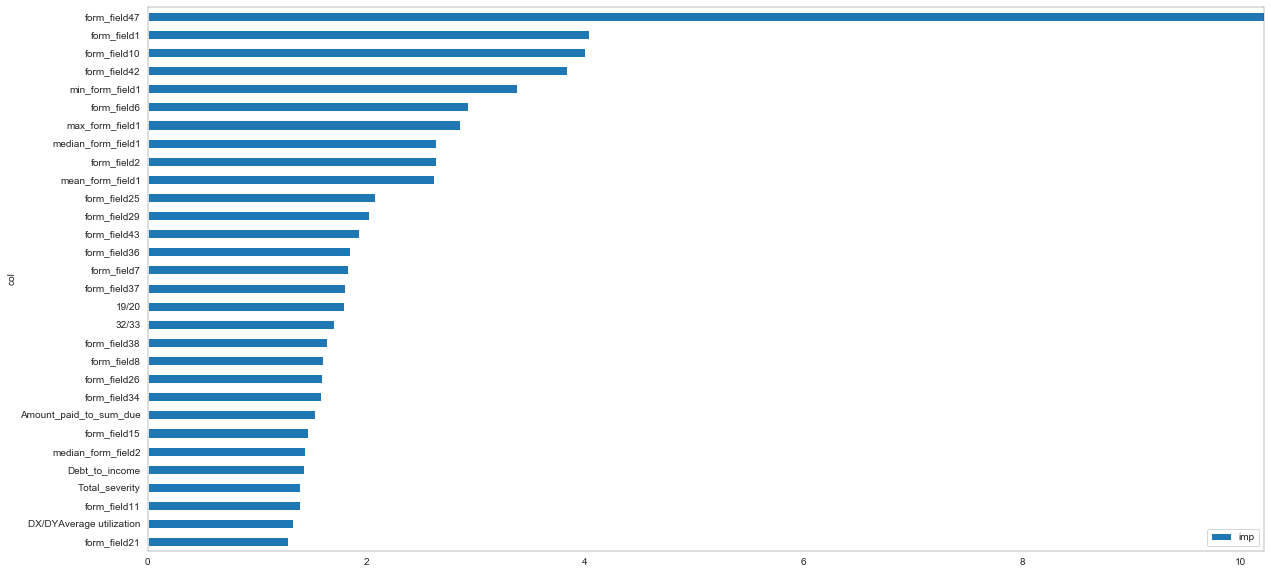

In [395]:
fea_imp = pd.DataFrame({'imp':m.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
plt.savefig('catboost_feature_importance.png')